In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.voc_detection import VOCMApMetric
from importlib import reload
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics
import time

# Local Libraries
import pedestrian
import utils

# GPU mode
ctx = mx.gpu()

/home/andres/.local/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/

reload(pedestrian)

pedestrian_path = os.getcwd()
pedestrian_dataset = pedestrian.PedestrianDataset(pedestrian_path)

Read 170 images with 423 pedestrians


23 pedestrians in 10 images


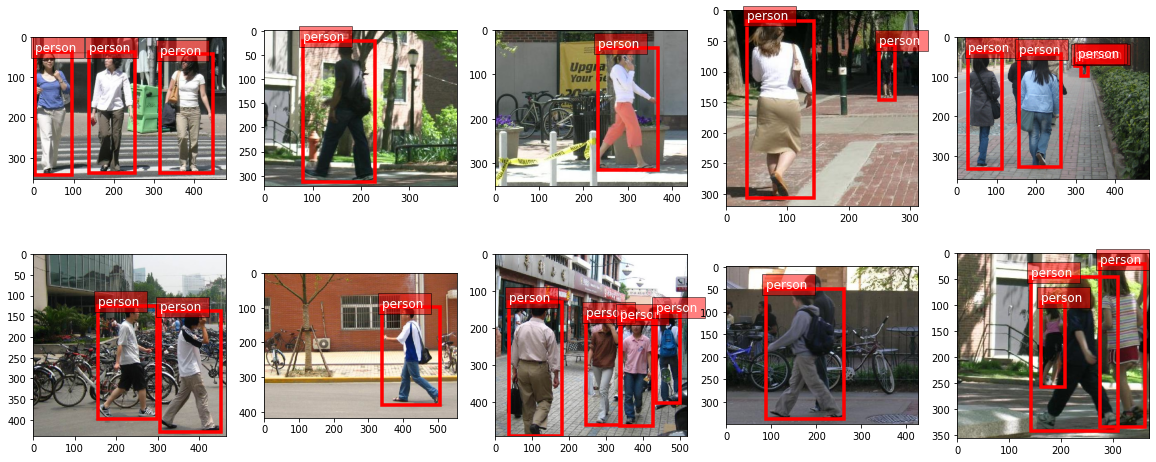

In [4]:
# Display 10 images from the dataset
# 5 x 2 grid
num_images_to_plot = 10
num_columns = 5

fig = plt.figure(figsize=(20, 8))

images_plotted = 0

number_pedestrians = 0

for (X, y) in pedestrian_dataset:
        
    # Format inputs
    image = X
    gt_bboxes = y
    
    number_pedestrians += len(gt_bboxes)

    axes = fig.add_subplot(2, 5, images_plotted + 1)
    gcv.utils.viz.plot_bbox(image, gt_bboxes, class_names=["person"], ax=axes)

    images_plotted += 1

    if images_plotted == num_images_to_plot:
        # We are done
        break
        
print(str(number_pedestrians) + " pedestrians in " + str(images_plotted) + " images")

In [55]:
faster_rcnn = gcv.model_zoo.get_model("faster_rcnn_fpn_resnet101_v1d_coco", pretrained=True, ctx=ctx)

In [46]:
transformed_image, new_image = gcv.data.transforms.presets.rcnn.transform_test(image)

In [47]:
new_gt_bboxes = pedestrian.PedestrianDataset.scale_bboxes(gt_bboxes, new_image.shape, image.shape)

In [48]:
output = faster_rcnn(transformed_image.as_in_context(ctx))

In [19]:
class_indices, class_probs, bboxes = pedestrian.PedestrianDataset.filter_person(output)

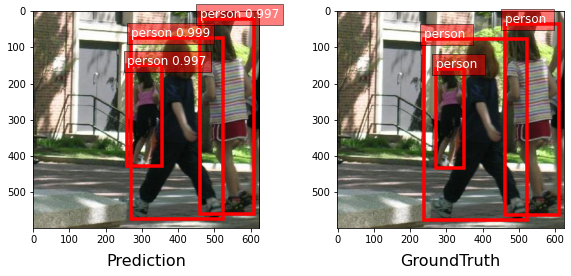

In [20]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
gcv.utils.viz.plot_bbox(new_image, bboxes[0], class_probs[0], class_indices[0], class_names=faster_rcnn.classes, ax=axes)
axes.set_title("Prediction", fontsize=16, y=-0.2)
axes = fig.add_subplot(1, 2, 2)
gcv.utils.viz.plot_bbox(new_image, new_gt_bboxes, class_names=["person"], ax=axes)
axes.set_title("GroundTruth", fontsize=16, y=-0.2);

In [21]:
yolo = gcv.model_zoo.get_model("yolo3_darknet53_coco", pretrained=True, ctx=ctx)

In [22]:
transformed_image, new_image = gcv.data.transforms.presets.yolo.transform_test(image)

In [23]:
new_gt_bboxes = pedestrian.PedestrianDataset.scale_bboxes(gt_bboxes, new_image.shape, image.shape)

In [24]:
output = yolo(transformed_image.as_in_context(ctx))

[20:20:21] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [25]:
output[0].shape, output[1].shape, output[2].shape

((1, 100, 1), (1, 100, 1), (1, 100, 4))

In [18]:
class_indices, class_probs, bboxes = pedestrian.PedestrianDataset.filter_person(output)

[20:40:09] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


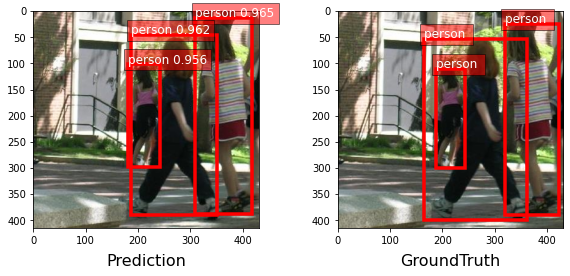

In [19]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
gcv.utils.viz.plot_bbox(new_image, bboxes[0], class_probs[0], class_indices[0], class_names=faster_rcnn.classes, ax=axes)
axes.set_title("Prediction", fontsize=16, y=-0.2)
axes = fig.add_subplot(1, 2, 2)
gcv.utils.viz.plot_bbox(new_image, new_gt_bboxes, class_names=["person"], ax=axes)
axes.set_title("GroundTruth", fontsize=16, y=-0.2);

In [20]:
mAP = VOCMApMetric()

start_time = time.time()

for (X, y) in pedestrian_dataset:
        
    # Format inputs
    image = X
    gt_bboxes = mx.nd.array([y])
    # Same class Indices (0: Person)
    class_indices = mx.nd.array([[0] * len(gt_bboxes)])
    
    transformed_image, scaled_image = gcv.data.transforms.presets.rcnn.transform_test(image)
    
    scaled_gt_bboxes = pedestrian.PedestrianDataset.scale_bboxes(gt_bboxes, scaled_image.shape, image.shape)
    
    output = faster_rcnn(transformed_image.as_in_context(ctx))
    filtered_indices, filtered_probs, filtered_bboxes = pedestrian.PedestrianDataset.filter_person(output)
    
    mAP.update(filtered_bboxes, filtered_indices, filtered_probs, scaled_gt_bboxes, class_indices)
    
print(mAP.get())
print("Elapsed Time: ", time.time() - start_time ,"secs")

[20:40:18] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:40:22] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:40:27] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:40:33] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:40:37] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running perf

[20:42:31] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:42:34] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:42:38] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:42:41] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:42:46] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running perf

('VOCMeanAP', 0.6716161702078043)
Elapsed Time:  249.30912852287292 secs


In [22]:
mAP = VOCMApMetric()

start_time = time.time()

for (X, y) in pedestrian_dataset:
        
    # Format inputs
    image = X
    gt_bboxes = mx.nd.array([y])
    # Same class Indices (0: Person)
    class_indices = mx.nd.array([[0] * len(gt_bboxes)])
    
    transformed_image, scaled_image = gcv.data.transforms.presets.yolo.transform_test(image)
    
    scaled_gt_bboxes = pedestrian.PedestrianDataset.scale_bboxes(gt_bboxes, scaled_image.shape, image.shape)
    
    output = yolo(transformed_image.as_in_context(ctx))
    filtered_indices, filtered_probs, filtered_bboxes = pedestrian.PedestrianDataset.filter_person(output)
    
    mAP.update(filtered_bboxes, filtered_indices, filtered_probs, scaled_gt_bboxes, class_indices)

    
print(mAP.get())
print("Elapsed Time: ", time.time() - start_time ,"secs")

[20:44:56] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:45:01] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:45:05] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:45:09] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[20:45:14] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running perf

('VOCMeanAP', 0.5339115787945962)
Elapsed Time:  113.4049768447876 secs
